In [1]:
# %load mnist_softmax_gd_tf_summary_test.py
# Copyright (c) 2016-2017, Deogtae Kim & DTWARE Inc. All rights reserved.
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = ","
# del os.environ["CUDA_VISIBLE_DEVICES"]

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

tf.reset_default_graph()
tf.set_random_seed(107)

C:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
## 데이터 수집

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


<class 'tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet'>
['__add__', '__class__', '__contains__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getnewargs__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__mul__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__rmul__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '_asdict', '_fields', '_make', '_replace', '_source', 'count', 'index', 'test', 'train', 'validation']
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(55000, 784)
(784,)
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0. 

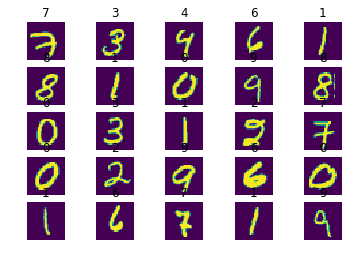

In [3]:
## 데이터 시각화, 전처리

print(type(mnist.train))
print(dir(mnist))
print(type(mnist.train.images), type(mnist.train.labels))
print(mnist.train.images.shape)
print(mnist.train.images[0].shape)
print(mnist.train.images[0])
print(mnist.train.labels.shape)
print(mnist.train.labels[0].shape)
print(mnist.train.labels[0])
print(mnist.train.num_examples, mnist.train.images.shape, mnist.train.labels.shape)
print(mnist.validation.num_examples, mnist.validation.images.shape, mnist.validation.labels.shape)
print(mnist.test.num_examples, mnist.test.images.shape, mnist.test.labels.shape)

fig, axes = plt.subplots(5, 5)
for i in range(5):
    for j in range(5):
        axes[i,j].axis('off')
        axes[i,j].imshow(mnist.train.images[i*5+j].reshape(28,28))
        axes[i,j].set_title("%d" % np.argmax(mnist.train.labels[i*5+j]))

In [4]:
## 예측 모델 정의: 소프트맥스 회귀 모델

X = tf.placeholder(tf.float32, [None, 784])
Y = tf.placeholder(tf.float32, [None, 10])
W = tf.get_variable("W", initializer=tf.zeros([784, 10]))
b = tf.get_variable("b", initializer=tf.zeros([10]))
# 각 데이터에 대한 각 분류별 점수
score = tf.matmul(X, W) + b
# 각 데이터에 대한 각 분류별 확률
pred = tf.nn.softmax(score)

In [5]:
## 손실 함수, 정확도, 최적화 함수 정의

cost = tf.reduce_mean(-tf.reduce_sum(Y * tf.log(pred), reduction_indices=[1]))
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
#train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cost)
train_step = tf.train.AdamOptimizer(0.001).minimize(cost)

In [6]:
# 로그 초기화

tf.summary.histogram("W histogram", W)
tf.summary.histogram("b histogram", b)
tf.summary.scalar("cost", cost)
tf.summary.scalar("accuracy", accuracy)

summary_op = tf.summary.merge_all()
saver = tf.train.Saver()

sess = tf.Session()
summary_writer = tf.summary.FileWriter("mnist_logs/", sess.graph)

INFO:tensorflow:Summary name W histogram is illegal; using W_histogram instead.
INFO:tensorflow:Summary name b histogram is illegal; using b_histogram instead.


In [7]:
## 훈련

sess.run(tf.global_variables_initializer())
import time
start = time.time()
for epoch in range(50):
    avg_cost = 0
    batch_count = int(mnist.train.num_examples / 100)
    for _ in range(batch_count):
        batch_xs, batch_ys = mnist.train.next_batch(100)
        c, _  = sess.run([cost, train_step], feed_dict={X: batch_xs, Y: batch_ys})
        avg_cost += c / batch_count
#    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost), 
#          ', accuacy = ', '{:.9f}'.format(sess.run(accuracy, feed_dict={X: mnist.test.images, Y: mnist.test.labels})))
    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost), 
          ', validation accuacy = ', '{:.9f}'.format(sess.run(accuracy, feed_dict={X: mnist.validation.images, Y: mnist.validation.labels})))
    summary_str = sess.run(summary_op, feed_dict={X: mnist.validation.images, Y: mnist.validation.labels})
    summary_writer.add_summary(summary_str, epoch)
    saver.save(sess, "mnist_logs/model-checkpoint", global_step=epoch)
    
print('accuacy = ', '{:.9f}'.format(sess.run(accuracy, feed_dict={X: mnist.test.images, Y: mnist.test.labels})))
print("훈련 시간:", time.time() - start)  

## 모델 평가

print(sess.run(accuracy, feed_dict={X: mnist.test.images, Y: mnist.test.labels}))
sess.close()

Epoch: 0001 cost = 0.636054703 , validation accuacy =  0.904600024
Epoch: 0002 cost = 0.352499398 , validation accuacy =  0.916000009
Epoch: 0003 cost = 0.314358225 , validation accuacy =  0.921400011
Epoch: 0004 cost = 0.296222517 , validation accuacy =  0.924199998
Epoch: 0005 cost = 0.285374971 , validation accuacy =  0.925000012
Epoch: 0006 cost = 0.278079598 , validation accuacy =  0.924799979
Epoch: 0007 cost = 0.272454667 , validation accuacy =  0.926800013
Epoch: 0008 cost = 0.268070136 , validation accuacy =  0.926800013
Epoch: 0009 cost = 0.264922470 , validation accuacy =  0.927800000
Epoch: 0010 cost = 0.261458108 , validation accuacy =  0.927399993
Epoch: 0011 cost = 0.258731181 , validation accuacy =  0.929199994
Epoch: 0012 cost = 0.256848205 , validation accuacy =  0.927200019
Epoch: 0013 cost = 0.254830392 , validation accuacy =  0.929799974
Epoch: 0014 cost = 0.252935020 , validation accuacy =  0.930199981
Epoch: 0015 cost = 0.251563918 , validation accuacy =  0.93120

c:\Anaconda3\scripts\tensorboard --logdir mnist_logs

웹 브라우저로 http://localhost:6006 방문